## Adversarial Validation

In [ ]:
import pandas as pd
from category_encoders import TargetEncoder
import xgboost as xgb
from xgboost import cv
from xgboost import XGBClassifier
%matplotlib inline
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv("../data/data.csv")
data_bis = data
data = data.drop(['hotel_id','avatar_name','order_requests','Unnamed: 0'], axis = 1)
data_bis = data_bis.drop(['Unnamed: 0'], axis = 1)

In [ ]:
dict_city = data.groupby("city")["price"].mean().to_dict()
dict_language = data.groupby("language")["price"].mean().to_dict()
dict_brand = data.groupby("brand")["price"].mean().to_dict()
dict_group = data.groupby("group")["price"].mean().to_dict()

In [ ]:
encoder = TargetEncoder()
data['city'] = encoder.fit_transform(data['city'],data['price'])
data['language'] = encoder.fit_transform(data['language'],data['price'])
data['brand'] = encoder.fit_transform(data['brand'],data['price'])
data['group'] = encoder.fit_transform(data['group'],data['price'])

d:\Logiciels\Anaconda\Installation\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
d:\Logiciels\Anaconda\Installation\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [ ]:
df_train = data.drop('price', axis = 1)
df_train['sample'] = 0  

In [ ]:
## Préparation du jeu de données test
test=pd.read_csv("../data/test_set.csv",sep=",",header=0)
test=test.drop(['order_requests'],axis=1)
bis=test

test=test.drop(['index'],axis=1)
features=pd.read_csv("../data/features_hotels.csv",sep=",",header=0)
features_test=features.loc[features["hotel_id"].loc[test['hotel_id']]]
features_test=features_test.reset_index()
df=pd.concat([features_test,test[['stock','date','language',"mobile"]]],axis=1)
#df.index=df['hotel_id']
df=df.drop(['hotel_id'],axis=1)
df=df.drop(['index'],axis=1)
# df = df.assign(date_circ = df["date"]%7)
# df = df.assign(average_temp = df["city"])
# df['average_temp'] = df['average_temp'].map(dict_temperature)
# df = df.assign(pib_country = df["city"])
# df['pib_country'] = df['pib_country'].map(dict_pib)
df['city']=df['city'].map(dict_city)
df['group']=df['group'].map(dict_group)
df['brand']=df['brand'].map(dict_brand)
df['language']=df['language'].map(dict_language)

df['sample'] = 1

df_test = df

In [ ]:
df_test

,group,brand,city,parking,pool,children_policy,stock,date,language,mobile,sample
0,139.766780,153.930247,114.537928,1,0,0,46,21,175.980504,0,1
1,196.615608,205.933677,114.537928,1,1,0,32,21,175.980504,0,1
2,99.729948,99.729948,114.537928,1,0,0,12,21,175.980504,0,1
3,196.615608,84.326869,114.537928,0,0,0,10,21,175.980504,0,1
4,196.615608,304.782218,114.537928,1,1,1,42,21,175.980504,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6639,196.615608,84.326869,156.760340,1,0,0,1,5,161.814154,0,1
6640,196.615608,205.933677,163.986638,1,0,0,1,1,161.814154,1,1
6641,139.766780,127.270250,163.986638,1,0,0,0,1,161.814154,1,1
6642,156.351497,164.510174,163.986638,1,0,0,0,1,161.814154,1,1


## Adversarial validation

In [ ]:
all_data = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# shuffle
all_data_shuffled = all_data.sample(frac=1)

# create our DMatrix (the XGBoost data structure)
X = all_data_shuffled.drop(['sample'], axis=1)
y = all_data_shuffled['sample']
XGBdata = xgb.DMatrix(data=X,label=y)

# our XGBoost parameters
params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

# perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20, as_pandas = True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

199    0.935359
Name: test-auc-mean, dtype: float64


d:\Logiciels\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


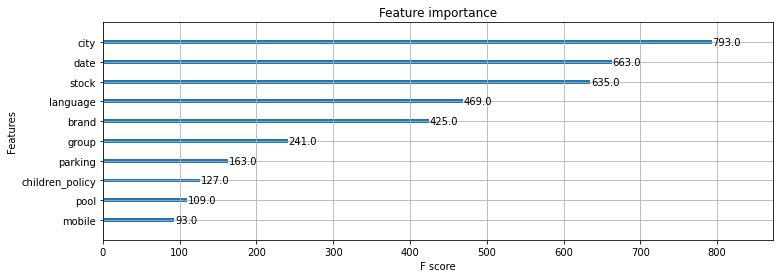

In [ ]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show()

<font color='blue'> Nous remarquons ici que les variables ville et date sont celles qui font la plus grande distinction entre l'échantillon test et l'échantillon train. Cependant, cela ne nous semble pas réaliste de les supprimer car elles jouent un rôle important dans la prédiction du prix. <font>

<font color='blue'> Nous allons par la suite supprimer les lignes de notre jeu de train qui diffèrent trop de notre jeu de train. <font>

In [ ]:
from sklearn import model_selection as CV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, PolynomialFeatures
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import accuracy_score as accuracy
import numpy as np

from time import ctime

print("loading")

train = df_train
test = df_test

orig_train = train.copy()

train = pd.concat(( orig_train, test ))
train.reset_index( inplace = True, drop = True )

x = train.drop( ['sample'], axis = 1 )
y = train.sample
y = train['sample']

print("cross-validating...")

n_estimators = 100
clf = RF( n_estimators = n_estimators, n_jobs = -1 )

predictions = np.zeros(y.shape)

cv = CV.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 5678)

for f, ( train_i, test_i ) in enumerate(cv.split(x,y)):

    print("# fold {}, {}".format( f + 1, ctime()))

    x_train = x.iloc[train_i]
    x_test = x.iloc[test_i]
    y_train = y.iloc[train_i]
    y_test = y.iloc[test_i]
    clf.fit( x_train, y_train )

    p = clf.predict_proba(x_test)[:,1]

    auc = AUC( y_test, p )
    print("# AUC: {:.2%}\n".format( auc ))

    predictions[ test_i ] = p

train['p'] = predictions

i = predictions.argsort()
train_sorted = train.iloc[i]

loading
cross-validating...
# fold 1, Fri Jan  6 14:41:13 2023
# AUC: 96.24%

# fold 2, Fri Jan  6 14:41:32 2023
# AUC: 95.95%

# fold 3, Fri Jan  6 14:41:53 2023
# AUC: 96.22%

# fold 4, Fri Jan  6 14:42:11 2023
# AUC: 95.97%

# fold 5, Fri Jan  6 14:42:28 2023
# AUC: 96.47%



<font color = 'blue'> On ne conserve que les lignes qui ont une proba d'appartenir au test non nulle <font>

In [ ]:
train_sorted_train = train_sorted[train_sorted['sample'] == 0]
tab_final = train_sorted_train[train_sorted_train['p'] != 0]
tab = data_bis.iloc[tab_final.index]

In [ ]:
tab

,hotel_id,group,brand,city,parking,pool,children_policy,price,stock,date,language,mobile,avatar_name,order_requests
161091,143,Boss Western,Boss Western,sofia,0,0,0,83,0,0,hungarian,1,hongrois,9
176801,143,Boss Western,Boss Western,sofia,0,0,0,83,0,0,hungarian,1,hongrois,9
302843,544,Independant,Independant,sofia,1,0,0,66,0,0,bulgarian,0,lesfrites,24
302884,4,Independant,Independant,sofia,1,0,0,44,0,0,bulgarian,0,lesfrites,24
302878,553,Independant,Independant,sofia,1,0,0,101,0,0,bulgarian,0,lesfrites,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279840,917,Morriott International,Corlton,amsterdam,1,1,0,421,3,3,romanian,1,romany,17
270116,411,Independant,Independant,madrid,0,0,0,90,39,38,hungarian,0,hungarian2,3
487831,411,Independant,Independant,madrid,0,0,0,98,37,37,danish,0,danishman,4
120834,411,Independant,Independant,madrid,0,0,0,92,34,36,belgian,0,jc,9


<font color = 'blue' > Ainsi, parmi les 600 000 lignes présentes initialement, on n'en conserve qu'environ 54 000. <font>

In [ ]:
tab.to_csv("../data/data_improved.csv",index = False)